<a href="https://colab.research.google.com/github/Iman6243/AI/blob/main/DecitionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
%reset -f
#del my_variable

## Packes

In [72]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statistics import mean
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from numpy import array
import os
#ِDT
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

#
import scipy.signal as signal
import time, calendar, datetime
import plotly.graph_objects as go
# SuperFastPython.com
# unzip a large number of files concurrently with processes and threads in batch
from os import makedirs
from os.path import join
from zipfile import ZipFile
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import ThreadPoolExecutor
from scipy.signal import find_peaks
#from vector import vector, plot_peaks
#from libs import detect_peaks
#from peakdetect import peakdetect
import seaborn as sns
try:
  from google.colab import files
  from google.colab import drive
  colab_env = True
except ImportError: colab_env = False

## Functions

In [79]:
def bandpass_filter_fft_and_plot(dataframe,filename,fs, lowcut, highcut, order=4):
    """
    فیلتر کردن تک‌تک ستون‌های دیتافریم با استفاده از فیلتر باند-پاس، اعمال FFT و رسم نمودارهای سیگنال اصلی و فیلتر شده

    پارامترها:
    dataframe -- دیتافریم شامل داده‌ها
    fs -- نرخ نمونه‌برداری
    lowcut -- فرکانس برش پایین (Hz)
    highcut -- فرکانس برش بالا (Hz)
    order -- مرتبه فیلتر (پیش‌فرض: 4)

    بازگشت:
    filtered_dataframe -- دیتافریم شامل ستون‌های فیلتر شده
    """
    filterd_signals = {}
    first_column_name = dataframe.columns[0] # Get the name of the first column
    t = np.arange(len(dataframe[first_column_name]))

    # طراحی فیلتر Butterworth باند-پاس
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')

    # ایجاد دیتافریم جدید برای ذخیره نتایج فیلتر شده
    filtered_dataframe = pd.DataFrame(index=dataframe.index)

    # تنظیم اندازه شکل نمودار
    plt.figure(figsize=(15, len(dataframe.columns) * 10))

    # فیلتر کردن تک‌تک ستون‌های دیتافریم، اعمال FFT و رسم نمودارها
    for i, column in enumerate(dataframe.columns, start=1):
        # فیلتر کردن ستون
        filtered_dataframe[column] = signal.filtfilt(b, a, dataframe[column])

        # نمودار سیگنال اصلی و فیلتر شده در حوزه زمان
        plt.subplot(len(dataframe.columns), 4, i * 4 - 3)
        plt.plot(dataframe.index, dataframe[column], label='Original')
        plt.title(f'Original Signal - {column}')
        plt.xlabel('Time')
        plt.ylabel(column)
        plt.legend()
        plt.gca().spines[['top', 'right']].set_visible(False)

        plt.subplot(len(dataframe.columns), 4, i * 4 - 2)
        plt.plot(dataframe.index, filtered_dataframe[column], label='Filtered', color='orange')
        plt.title(f'Filtered Signal - {column}')
        plt.xlabel('Time')
        plt.ylabel(column)
        plt.legend()
        plt.gca().spines[['top', 'right']].set_visible(False)

        # اعمال FFT به سیگنال اصلی و فیلتر شده
        n = len(dataframe[column])
        t = np.arange(n) / fs
        f = np.fft.fftfreq(n, d=1/fs)
        X = np.fft.fft(dataframe[column])
        Y = np.fft.fft(filtered_dataframe[column])
        mask = f >= 0
        f = f[mask]
        X = X[mask]
        Y = Y[mask]

        # نمودار سیگنال اصلی و فیلتر شده در حوزه فرکانس
        plt.subplot(len(dataframe.columns), 4, i * 4 - 1)
        plt.plot(f, np.abs(X), label='Original Frequency Domain')
        plt.title(f'Original Signal Frequency - {column}')
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Magnitude')
        plt.legend()
        plt.gca().spines[['top', 'right']].set_visible(False)

        plt.subplot(len(dataframe.columns), 4, i * 4)
        plt.plot(f, np.abs(Y), label='Filtered Frequency Domain', color='orange')
        plt.title(f'Filtered Signal Frequency - {column}')
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Magnitude')
        plt.legend()
        plt.gca().spines[['top', 'right']].set_visible(False)

    plt.tight_layout()
    plt.show()

    # ایجاد نام فایل جدید با افزودن "_filtered" به نام فایل اصلی و ذخیره سیگنال فیلتر شده در یک فایل CSV
    #filtered_filename = save_filtered_signal(filename, t, filtered_dataframe)
    filtered_filename,filtered_signal_df = save_filtered_signal_with_extra_column(filename, t, filtered_dataframe)
    # دانلود فایل فیلتر شده
    #download_signal(filtered_filename)

    return filtered_dataframe,filtered_signal_df

def save_filtered_signal_with_extra_column(filename, t, FSig,column_prefix='Filtered_'):
    """
    ایجاد نام فایل جدید با افزودن "_filtered" به نام فایل اصلی و ذخیره سیگنال فیلتر شده در یک فایل CSV به همراه یک ستون جدید

    پارامترها:
    filename -- نام فایل اصلی
    t -- زمان
    FSig -- سیگنال فیلتر شده (دیتافریم شامل تمامی ستون‌های سیگنال)
    new_column_data -- داده‌های ستون جدید (باید به صورت لیست یا سری pandas باشد)
    new_column_name -- نام ستون جدید
    column_prefix -- پیشوند ستون‌ها برای سیگنال فیلتر شده (پیش‌فرض: 'Filtered_')
    """
    filterd_signals = {}
    # ایجاد نام فایل جدید با افزودن "_filtered" به نام فایل اصلی
    filtered_filename = os.path.splitext(filename)[0] + '_filtered.csv'

    # بررسی اینکه FSig یک DataFrame است
    if not isinstance(FSig, pd.DataFrame):
        raise ValueError("FSig باید یک DataFrame باشد")

    # اضافه کردن ستون زمان به دیتافریم سیگنال فیلتر شده
    FSig.insert(0, 'Time', t)

    # ذخیره سیگنال فیلتر شده در یک فایل CSV
    filtered_signal_df = FSig
    filtered_signal_df.columns = [column_prefix + col if col != 'Time' else col for col in filtered_signal_df.columns]
    filtered_signal_df.to_csv(filtered_filename, index=False)
    print(f"Filtered signal saved to '{filtered_filename}'")
    #pd.DataFrame(filtered_signal_df)
    return filtered_filename, pd.DataFrame(filtered_signal_df)

def show_max_peak_signal(dataframe,column,start_index=None,end_index=None):
    selected_rows = dataframe.iloc[start_index:end_index]
    signal = selected_rows[column]

    # یافتن پیک‌ها
    peaks, properties = find_peaks(signal, height=0)

    if len(peaks) > 0:
        # یافتن بزرگترین پیک
        max_peak_idx = peaks[np.argmax(properties['peak_heights'])]
        max_peak_value = signal.iloc[max_peak_idx]

        # یافتن کوچکترین پیک
        min_peak_idx = peaks[np.argmin(properties['peak_heights'])]
        min_peak_value = signal.iloc[min_peak_idx]

        # نمایش پیک‌ها در نمودار
        plt.figure(figsize=(12, 6))
        plt.plot(selected_rows.index, signal, label='Signal')
        plt.plot(selected_rows.index[peaks], signal.iloc[peaks], "x", label='Peaks')
        plt.plot(selected_rows.index[max_peak_idx], max_peak_value, "ro", label='Largest Peak')
        plt.plot(selected_rows.index[min_peak_idx], min_peak_value, "go", label='Smallest Peak')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Peaks in the Specified Range')
        plt.legend()
        plt.grid(True)
        plt.show()

        if max_peak_idx is not None:
          print(f"Index of the largest peak: {max_peak_idx}, Value: {max_peak_value}")
          print(f"Index of the smallest peak: {min_peak_idx}, Value: {min_peak_value}")
        return max_peak_idx, max_peak_value, min_peak_idx, min_peak_value
    else:
        print("No peaks found in the specified range")
        return None, None, None, None

def disply_signal(dataframe,column,start_index=None,end_index=None):
    if start_index is None:
      start_index = dataframe.index[0]
    if end_index is None:
      end_index = dataframe.index[-1]
    subset_df = dataframe.iloc[start_index:end_index]
    plt.figure(figsize=(12, 6))
    plt.plot(subset_df.index, subset_df[column], label='Signal')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Peaks in the Specified Range')
    plt.legend()
    plt.grid(True)
    plt.show()
    print(subset_df.shape)

def copy_dataset(datafram,start_index=None,end_index=None):
    if start_index is None:
        start_index = datafram.index[0]
    if end_index is None:
        end_index = datafram.index[-1]
    # انتخاب ردیف‌هایی که می‌خواهیم کپی کنیم
    selected_rows = datafram.iloc[start_index:end_index] # انتخاب ردیف‌های 2 تا 4 (اندیس 1 تا 3)
    # کپی ردیف‌های انتخاب شده به یک دیتافریم جدید
    copydf = selected_rows.copy()
    # ریست کردن اندیس‌های دیتافریم جدید
    copydf.reset_index(drop=True, inplace=True)
    return copydf

## Main Code

In [73]:
# لیست فایل‌ها در دایرکتوری فعلی
filess = os.listdir('.')
print(filess)

['.config', 'ForWard.csv', 'Accelerometer-COP.csv', 'Gyroscope-COP.csv', 'sample_data']


In [74]:
# فیلتر کردن فایل‌های CSV
filenames = [file for file in filess if file.endswith('.csv')]

# خواندن فایل‌های CSV
df_list = [pd.read_csv(file) for file in filenames]

In [75]:
# نمایش شکل هر دیتافریم
[print(f"Shape of dataframe {i+1}- {filenames[i]} : {df_list[i].shape}") for i in range(len(df_list))]

Shape of dataframe 1- ForWard.csv : (25000, 149)
Shape of dataframe 2- Accelerometer-COP.csv : (58933, 5)
Shape of dataframe 3- Gyroscope-COP.csv : (58934, 5)


[None, None, None]

In [78]:
Motion=df_list[0]
SigAcc=df_list[1]
SigGyr=df_list[2]

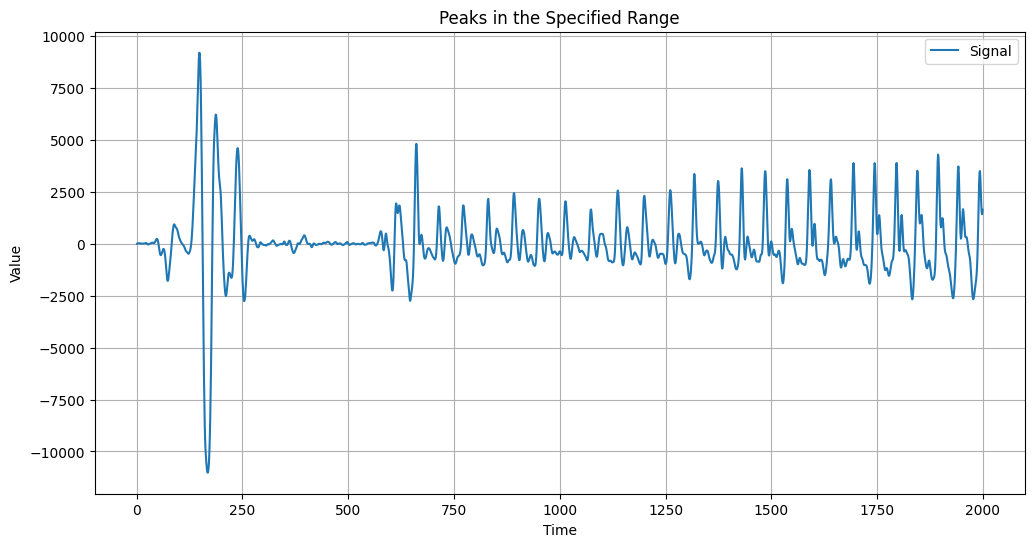

(2000, 149)


In [80]:
#Disply Motion
#t=df_list[1].set_index('Time',inplace=False)
disply_signal(Motion,'COPaZ1',0,2000)

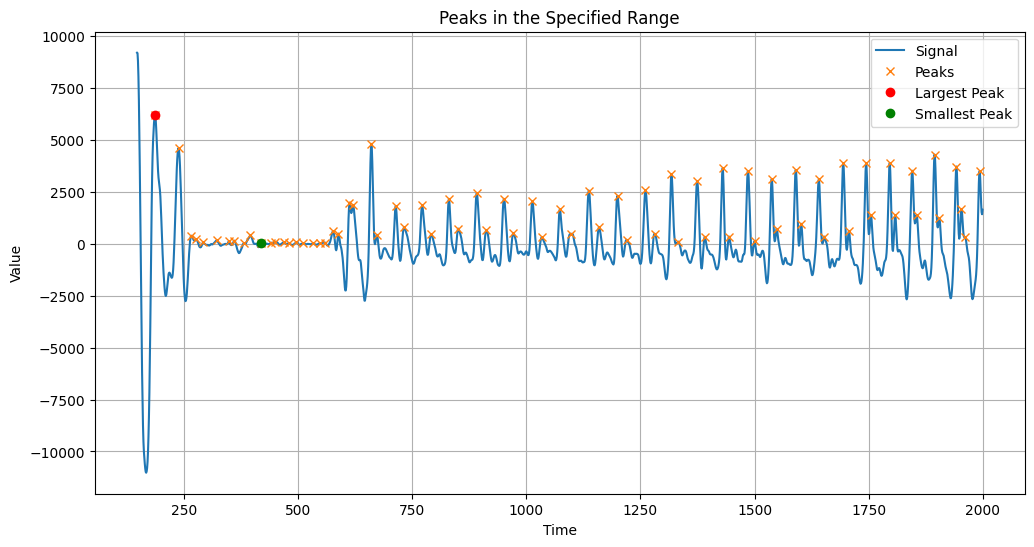

Index of the largest peak: 39, Value: 6212.1582
Index of the smallest peak: 271, Value: 9.76563
startMotion : 271 




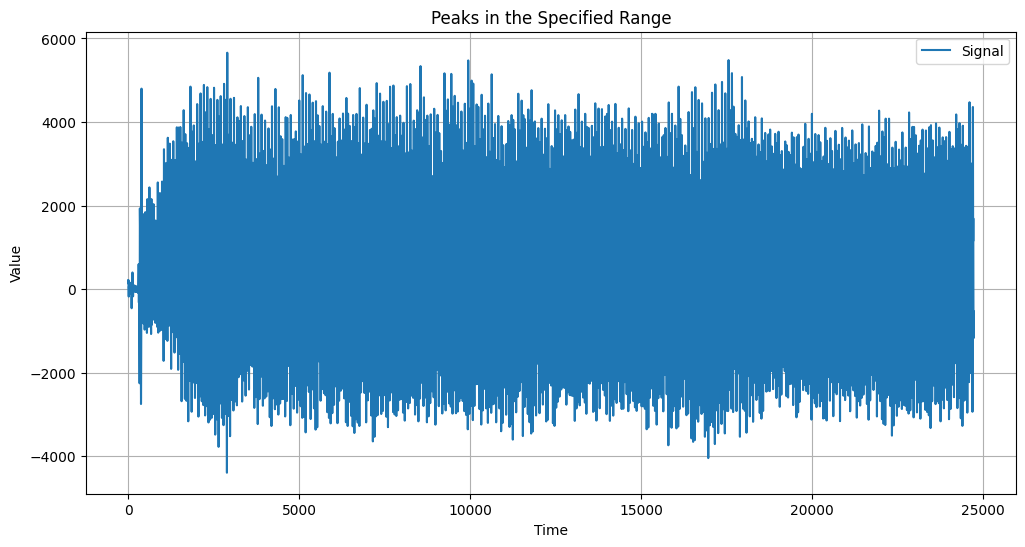

(24727, 149)
len of Motion : 24728


In [81]:
#Find Start of Motion
indxMax, Maxvalue, indxMin, Minvalue = show_max_peak_signal(Motion, 'COPaZ1', 148, 2000)#Motion
startMotion=indxMin
print(f"startMotion : {startMotion} \n\n")
#Display new data of Motion
# نمایش دیتافریم جدید
new_Motion=copy_dataset(Motion,startMotion)
disply_signal(new_Motion,'COPaZ1')# y==COPaZ1
lenmotion=len(new_Motion['Time'])
print(f"len of Motion : {len(new_Motion['Time'])}")

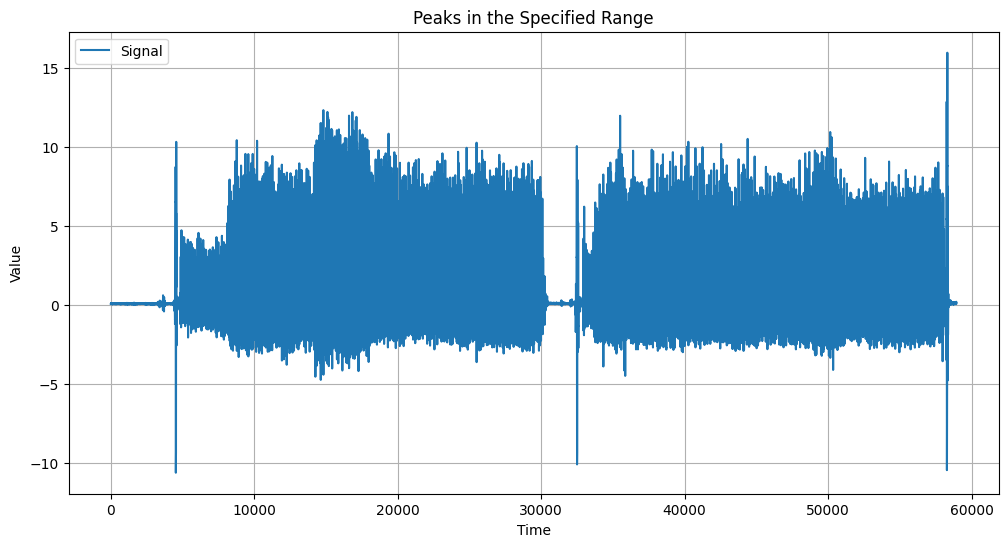

(58932, 5)


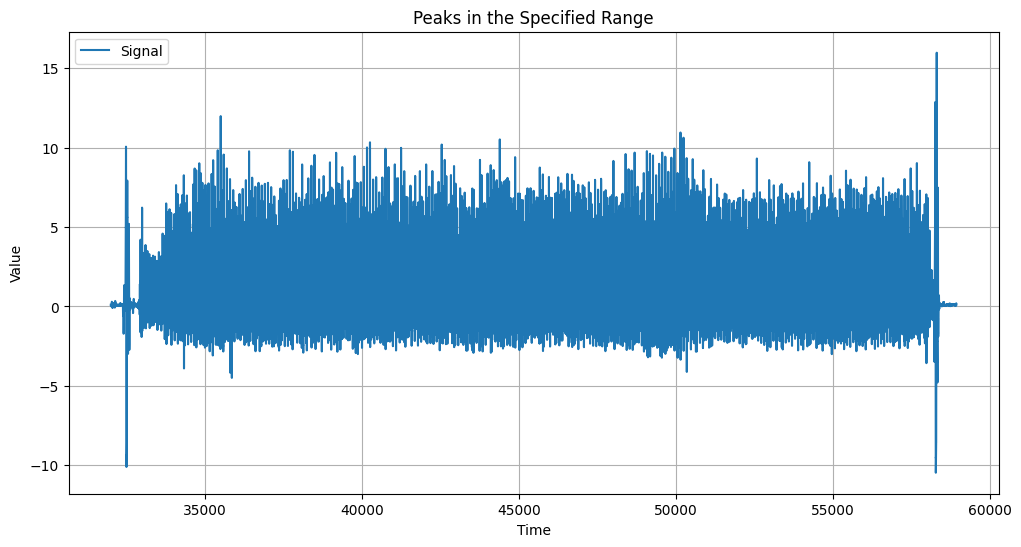

(26932, 5)




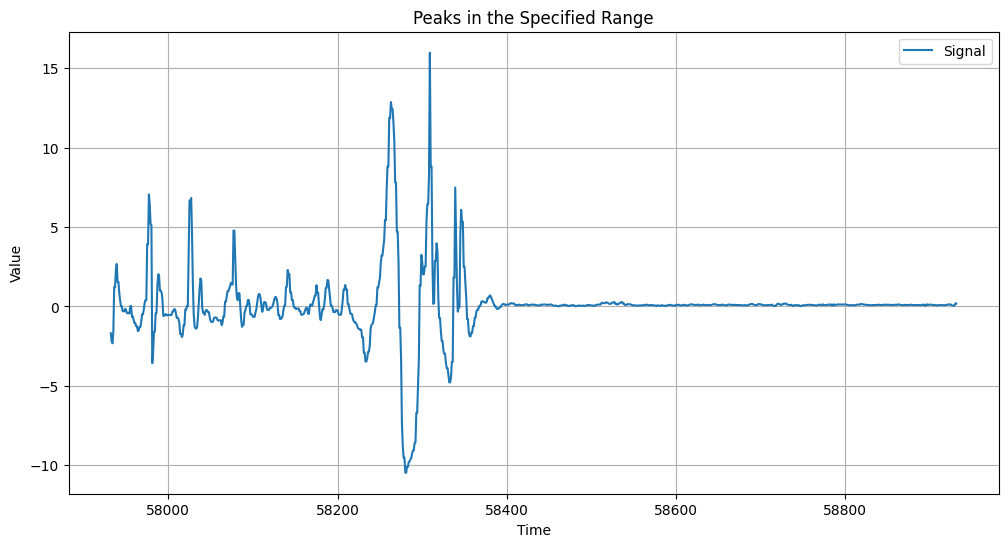

(1000, 5)


In [82]:
#Display Signal
#t=df_list[0].set_index('time',inplace=False)
last_indexds=SigAcc.index[-1]#Signal
Beforlast_indexds=last_indexds-1000
disply_signal(SigAcc,'y')# y==COPaZ1
disply_signal(SigAcc,'y',32000)# y==COPaZ1
print(f"\n")
disply_signal(SigAcc,'y',Beforlast_indexds,last_indexds)# y==COPaZ1

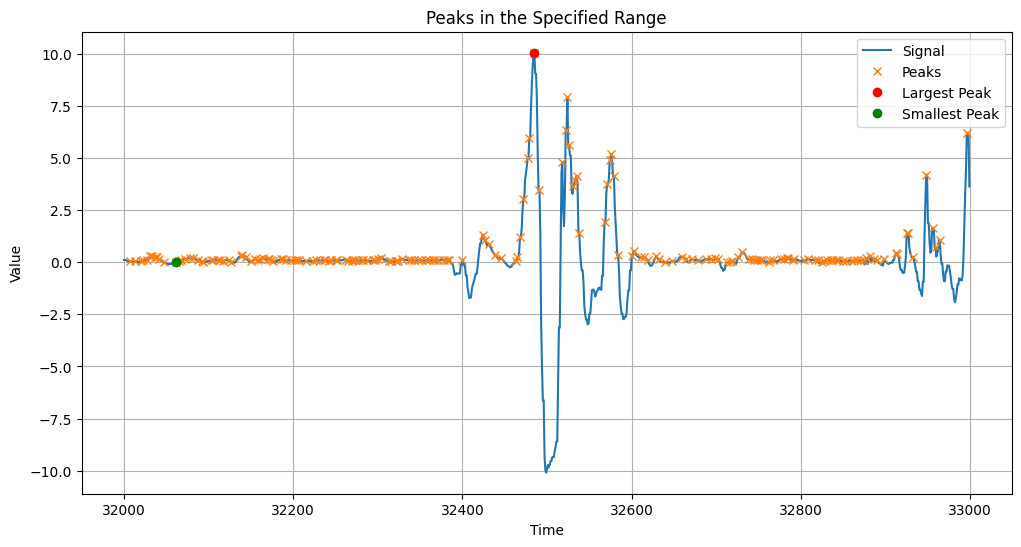

Index of the largest peak: 484, Value: 10.060951232910156
Index of the smallest peak: 61, Value: 0.0022783279418945
startSignal : 32483


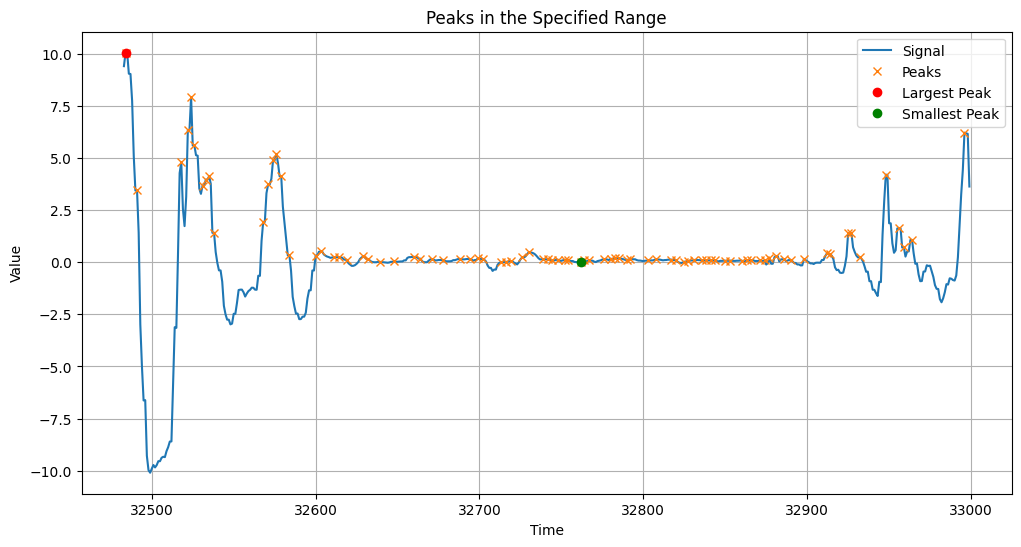

Index of the largest peak: 1, Value: 10.060951232910156
Index of the smallest peak: 279, Value: 0.0078067779541015
startSignal = 32483 + 484 : 32763


In [83]:
#t=df_list[0].set_index('time',inplace=False)
#Start Signal
indxMax0, Maxvalue, indxMin, Minvalue = show_max_peak_signal(SigAcc,'y', 32000,33000)#AccCop
startSignal0=(32000+indxMax0)-1
print(f"startSignal : {startSignal0}")
indxMax, Maxvalue, indxMin, Minvalue = show_max_peak_signal(SigAcc,'y', startSignal0,33000)#AccCop
startSignal=startSignal0+indxMin+1
print(f"startSignal = {startSignal0} + {indxMax0} : {startSignal}")

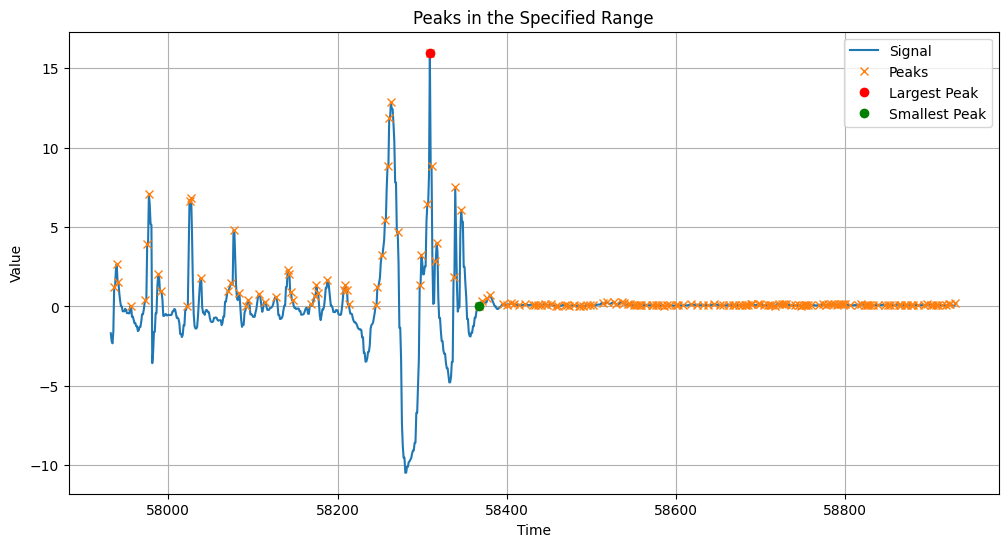

Index of the largest peak: 377, Value: 15.976947784423828
Index of the smallest peak: 435, Value: 0.0087699890136718
endSignal0 : 58311


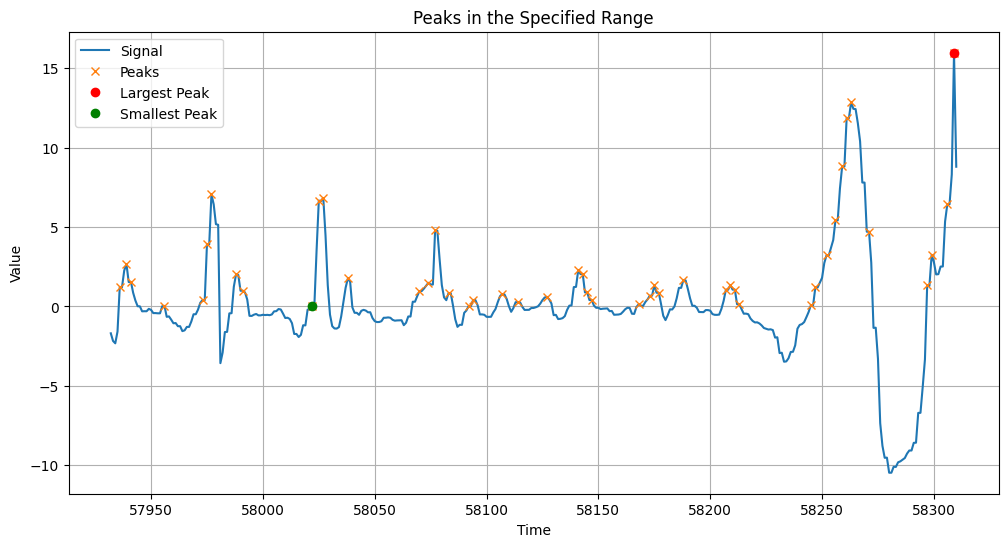

Index of the largest peak: 377, Value: 15.976947784423828
Index of the smallest peak: 90, Value: 0.0287761688232421
endSignal = 58311 - 90 - 2 : 58219


In [84]:
#End Signal
indxMax0, Maxvalue, indxMin, Minvalue = show_max_peak_signal(SigAcc,'y', Beforlast_indexds,last_indexds)#AccCop
endSignal0=(indxMax0+Beforlast_indexds)+2
print(f"endSignal0 : {endSignal0}")
indxMax, Maxvalue, indxMin, Minvalue = show_max_peak_signal(SigAcc,'y', Beforlast_indexds,endSignal0)#AccCop
endSignal=endSignal0-indxMin-2
print(f"endSignal = {endSignal0} - {indxMin} - {2} : {endSignal}")

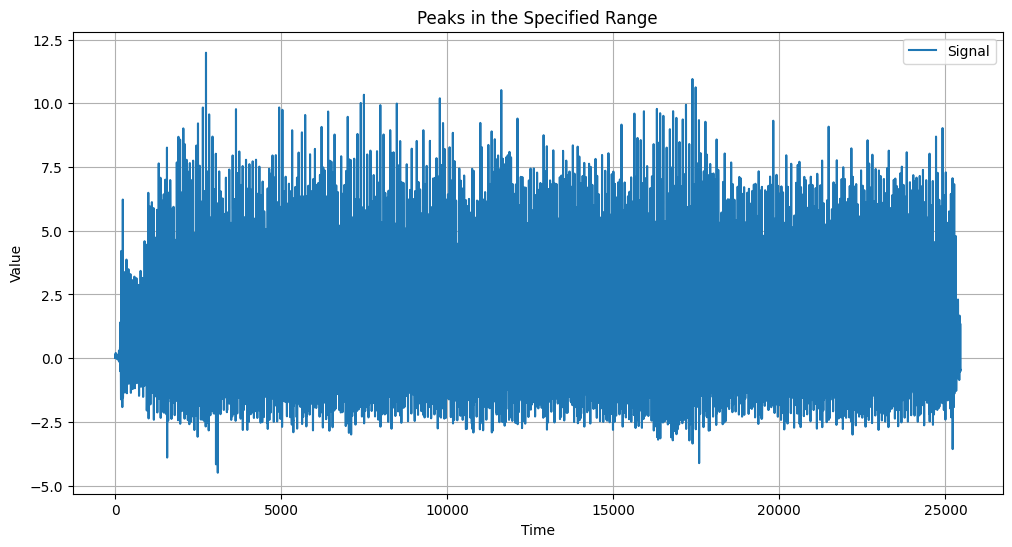

(25455, 5)
len of signal : 25456


In [85]:
# Dis play new data of Signal
# نمایش دیتافریم جدید
new_signal=copy_dataset(SigAcc,startSignal,endSignal)
disply_signal(new_signal,'y')# y==COPaZ1
lensignal=len(new_signal['time'])
print(f"len of signal : {len(new_signal['time'])}")

In [94]:
# ایجاد دو دیتافریم نمونه با بازه‌های زمانی متفاوت
new_Motion.set_index('Time', inplace=False)
new_signal.set_index('time', inplace=False)


Motion=new_Motion.values
SigAcc=new_signal.values
scaler_sig = MinMaxScaler()
scaler_motion = MinMaxScaler()
# Checking Lenghts
if lenmotion<lensignal:
    # برش سیگنال  به طول 24728 مربوط به موشن
    Signal_aligned = SigAcc[:lenmotion]
    # نرمال‌سازی داده‌های سیگنال
    Signal_normalized = scaler_sig.fit_transform(Signal_aligned)
    # نرمال‌سازی داده‌های زاویه‌ای
    y = Motion[:,146]  # هدف: ستون 147 سیگنال موشن
    y_normalized = scaler_motion.fit_transform(y.reshape(-1, 1))
else:
    Motion_aligned = Motion[:lensignal]
    y = Motion_aligned [:,146]  # هدف: ستون 147 سیگنال موشن
    # نرمال‌سازی داده‌های زاویه‌ای
    y_normalized = scaler_motion.fit_transform(y.reshape(-1, 1))
    # نرمال‌سازی داده‌های سیگنال
    Signal_normalized = scaler_sig.fit_transform(SigAcc)

# تقسیم داده‌ها به مجموعه‌های آموزشی و آزمایشی
X_train, X_test, y_train, y_test = train_test_split(Signal_normalized, y_normalized, test_size=0.2, random_state=42)

# آموزش مدل درخت تصمیم
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

# پیش‌بینی با استفاده از داده‌های آزمایشی
y_pred = model.predict(X_test)

# ارزیابی مدل
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 0.021449639504827093
R^2 Score: 0.70214092992733
